#### **Section 1: Import Libraries**

This section includes importing all the necessary libraries for data manipulation, text preprocessing, and visualization.



In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

# Download necessary NLTK resources (only needed the first time)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Set options to display more columns and rows in pandas for better analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Observation:
# This section sets up the environment with all necessary tools and resources for handling and visualizing the dataset.
# NLTK is used for natural language processing (tokenization, stopword removal, and lemmatization).


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Girija\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Girija\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Girija\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### **Section 2: Load the Dataset**

Here, the dataset is loaded from the file path, and an initial look at the dataset's structure is conducted to verify the columns and get a sense of the data.



In [2]:
# Step 2: Load the Dataset
file_path = "../data/raw/customer_support_dataset.csv"
df = pd.read_csv(file_path)

# Display column names to verify them
print("Columns in the dataset:")
print(df.columns)

# Observation:
# It is essential to verify column names to ensure that they align with our preprocessing script expectations.
# This helps in determining the correct column names for customer queries and support responses.


Columns in the dataset:
Index(['tweet_id', 'author_id', 'inbound', 'created_at', 'text',
       'response_tweet_id', 'in_response_to_tweet_id'],
      dtype='object')


#### **Section 3: Filter Customer Queries and Responses**

In this section, the dataset is filtered to separate customer queries (inbound) from support responses (outbound). We assume that each response directly follows a corresponding customer query.



In [3]:
# Set column names based on your dataset
# 'text' column contains message text, 'inbound' tells whether it is a customer query
TEXT_COLUMN = 'text'
INBOUND_COLUMN = 'inbound'

# Step 3: Filter Customer Queries and Responses
# Separate customer queries (inbound = True) and responses (inbound = False)
customer_queries = df[df[INBOUND_COLUMN] == True]
support_responses = df[df[INBOUND_COLUMN] == False]

# Reset indices for easier handling later
customer_queries.reset_index(drop=True, inplace=True)
support_responses.reset_index(drop=True, inplace=True)

# Combine customer queries and responses by aligning them on their conversational order
# Assuming that each response directly follows its corresponding query in the dataset
combined_df = pd.DataFrame({
    'customer_query': customer_queries[TEXT_COLUMN],
    'support_response': support_responses[TEXT_COLUMN]
})

# Drop rows with missing data to ensure clean pairs
combined_df.dropna(inplace=True)

# Observation:
# This section pairs customer queries with corresponding responses.
# The assumption here is that each response follows directly after its corresponding query.
# This assumption needs to be validated to ensure accuracy in conversational pairs.


#### **Section 4: Exploratory Data Analysis (EDA)**

This section includes exploring and analyzing the dataset, including checking data types, identifying missing values, and visualizing the length distributions of customer queries and responses.



<class 'pandas.core.frame.DataFrame'>
Index: 1273931 entries, 0 to 1273930
Data columns (total 2 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   customer_query    1273931 non-null  object
 1   support_response  1273931 non-null  object
dtypes: object(2)
memory usage: 29.2+ MB
None
Number of rows: 1273931, Number of columns: 2
Sample values for column 'customer_query':
0        @sprintcare and how do you propose we do that
1    @sprintcare I have sent several private messag...
2                                   @sprintcare I did.
3            @sprintcare is the worst customer service
4    @sprintcare You gonna magically change your co...
Name: customer_query, dtype: object 

Sample values for column 'support_response':
0    @115712 I understand. I would like to assist y...
1    @115712 Please send us a Private Message so th...
2    @115712 Can you please send us a private messa...
3    @115713 This is saddening to hear. Ple

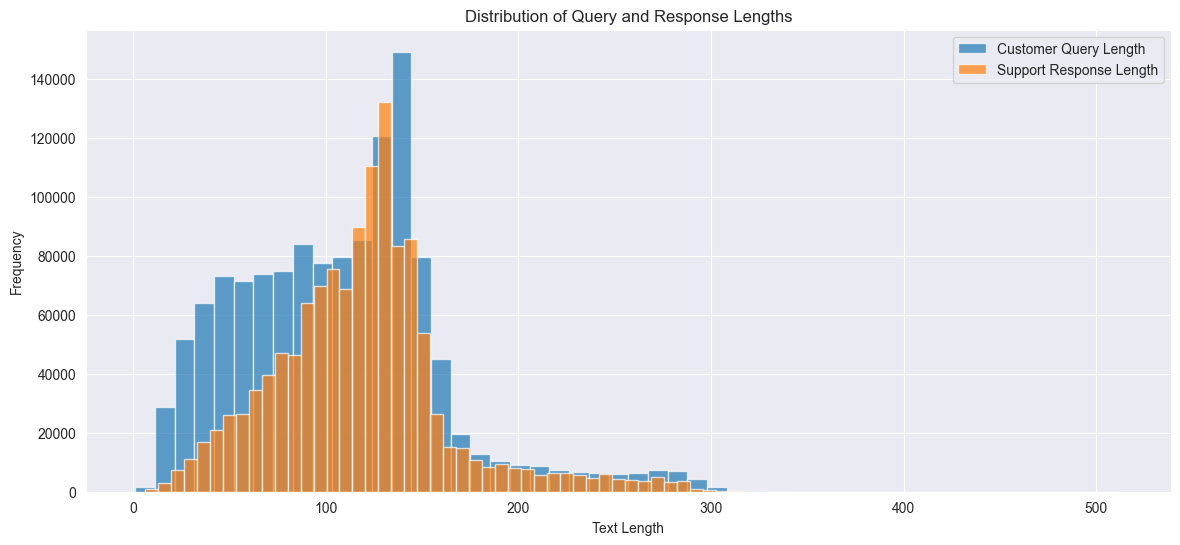

In [4]:
# Step 4: Exploratory Data Analysis (EDA)

# 4.1 Basic Information About Dataset
print(combined_df.info())
print(f"Number of rows: {combined_df.shape[0]}, Number of columns: {combined_df.shape[1]}")

# 4.2 Column Analysis
for column in combined_df.columns:
    print(f"Sample values for column '{column}':")
    print(combined_df[column].head(), '\n')

# 4.3 Handling Missing Values
print("Missing values in dataset:")
print(combined_df.isnull().sum())

# 4.4 Analysis of Text Fields
# Add columns for length of queries and responses
combined_df['query_length'] = combined_df['customer_query'].apply(lambda x: len(str(x)))
combined_df['response_length'] = combined_df['support_response'].apply(lambda x: len(str(x)))

# Plot distribution of text lengths
plt.figure(figsize=(14, 6))
plt.hist(combined_df['query_length'], bins=50, alpha=0.7, label='Customer Query Length')
plt.hist(combined_df['response_length'], bins=50, alpha=0.7, label='Support Response Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Query and Response Lengths')
plt.legend()
plt.show()

# Observation:
# The distribution of text lengths helps identify if there are very short or excessively long queries/responses.
# Such outliers might need special handling, as they could negatively affect model training.


#### **Section 5: Data Cleaning**

This section involves dropping irrelevant columns (if any), handling duplicate rows, and ensuring the data is clean for further processing.



In [5]:
# Step 5: Data Cleaning

# 5.1 Drop Irrelevant Columns (already filtered for relevant data)
# Note: No specific irrelevant columns were mentioned, so this step is skipped in practice.

# 5.2 Handling Duplicates
print(f"Number of duplicate rows: {combined_df.duplicated().sum()}")
combined_df.drop_duplicates(inplace=True)
print(f"Number of rows after dropping duplicates: {combined_df.shape[0]}")

# Observation:
# Duplicate rows are dropped to prevent redundancy, which could lead to biased training.


Number of duplicate rows: 0
Number of rows after dropping duplicates: 1273931


#### **Section 6: Text Preprocessing**

In this section, text preprocessing techniques are applied, such as normalization, tokenization, stop word removal, lemmatization, and entity replacement.

##### **6.1 Text Normalization**


In [6]:
# 6.1 Text Normalization
def normalize_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and numbers
    return text

combined_df['customer_query'] = combined_df['customer_query'].apply(normalize_text)
combined_df['support_response'] = combined_df['support_response'].apply(normalize_text)
print(combined_df[['customer_query', 'support_response']].head())

# Observation:
# Normalizing text by converting it to lowercase and removing special characters helps standardize the input.
# This step ensures that the model learns from a uniform text representation.


                                      customer_query  \
0       sprintcare and how do you propose we do that   
1  sprintcare i have sent several private message...   
2                                   sprintcare i did   
3           sprintcare is the worst customer service   
4  sprintcare you gonna magically change your con...   

                                    support_response  
0   i understand i would like to assist you we wo...  
1   please send us a private message so that we c...  
2   can you please send us a private message so t...  
3   this is saddening to hear please shoot us a d...  
4   we understand your concerns and wed like for ...  


In [7]:
# 6.2 Tokenization
combined_df['customer_query_tokens'] = combined_df['customer_query'].apply(word_tokenize)
combined_df['support_response_tokens'] = combined_df['support_response'].apply(word_tokenize)
print(combined_df[['customer_query_tokens', 'support_response_tokens']].head())


                               customer_query_tokens  \
0  [sprintcare, and, how, do, you, propose, we, d...   
1  [sprintcare, i, have, sent, several, private, ...   
2                               [sprintcare, i, did]   
3    [sprintcare, is, the, worst, customer, service]   
4  [sprintcare, you, gon, na, magically, change, ...   

                             support_response_tokens  
0  [i, understand, i, would, like, to, assist, yo...  
1  [please, send, us, a, private, message, so, th...  
2  [can, you, please, send, us, a, private, messa...  
3  [this, is, saddening, to, hear, please, shoot,...  
4  [we, understand, your, concerns, and, wed, lik...  


In [8]:
# 6.3 Stop Words Removal
stop_words = set(stopwords.words('english'))

combined_df['customer_query_tokens'] = combined_df['customer_query_tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])
combined_df['support_response_tokens'] = combined_df['support_response_tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])
print(combined_df[['customer_query_tokens', 'support_response_tokens']].head())



                               customer_query_tokens  \
0                              [sprintcare, propose]   
1  [sprintcare, sent, several, private, messages,...   
2                                       [sprintcare]   
3             [sprintcare, worst, customer, service]   
4  [sprintcare, gon, na, magically, change, conne...   

                             support_response_tokens  
0  [understand, would, like, assist, would, need,...  
1  [please, send, us, private, message, assist, c...  
2  [please, send, us, private, message, gain, det...  
3  [saddening, hear, please, shoot, us, dm, look,...  
4  [understand, concerns, wed, like, please, send...  


In [9]:
# 6.4 Lemmatization
lemmatizer = WordNetLemmatizer()

combined_df['customer_query_lemmatized'] = combined_df['customer_query_tokens'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])
combined_df['support_response_lemmatized'] = combined_df['support_response_tokens'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])
print(combined_df[['customer_query_lemmatized', 'support_response_lemmatized']].head())



                           customer_query_lemmatized  \
0                              [sprintcare, propose]   
1  [sprintcare, sent, several, private, message, ...   
2                                       [sprintcare]   
3             [sprintcare, worst, customer, service]   
4  [sprintcare, gon, na, magically, change, conne...   

                         support_response_lemmatized  
0  [understand, would, like, assist, would, need,...  
1  [please, send, u, private, message, assist, cl...  
2  [please, send, u, private, message, gain, deta...  
3  [saddening, hear, please, shoot, u, dm, look, kc]  
4  [understand, concern, wed, like, please, send,...  


In [10]:
# 6.5 Entity Removal
def replace_entities(text):
    text = re.sub(r'\b\d+\b', '<number>', text)  # Replace numeric values with <number>
    text = re.sub(r'\b[A-Z][a-z]*\b', '<name>', text)  # Replace proper nouns with <name>
    return text

combined_df['customer_query_cleaned'] = combined_df['customer_query'].apply(replace_entities)
combined_df['support_response_cleaned'] = combined_df['support_response'].apply(replace_entities)
print(combined_df[['customer_query_cleaned', 'support_response_cleaned']].head())


                              customer_query_cleaned  \
0       sprintcare and how do you propose we do that   
1  sprintcare i have sent several private message...   
2                                   sprintcare i did   
3           sprintcare is the worst customer service   
4  sprintcare you gonna magically change your con...   

                            support_response_cleaned  
0   i understand i would like to assist you we wo...  
1   please send us a private message so that we c...  
2   can you please send us a private message so t...  
3   this is saddening to hear please shoot us a d...  
4   we understand your concerns and wed like for ...  



Take 10% of the dataset for training since the dataset is heavy and it takes time while training

In [11]:
import pandas as pd

# 6.6 Sample 10% of the Dataset for Training and Testing
def sample_datasets(df, train_fraction=0.1, test_fraction=0.1, random_state=42):
    """
    Randomly sample fractions of the dataset for training and testing purposes.

    Args:
        df (DataFrame): The dataset to sample from.
        train_fraction (float): The fraction of the dataset to sample for training (default: 0.1).
        test_fraction (float): The fraction of the dataset to sample for testing (default: 0.1).
        random_state (int): Random seed for reproducibility (default: 42).

    Returns:
        Tuple[DataFrame, DataFrame]: The sampled subsets of the dataset for training and testing.
    """
    # Sample 10% for training
    train_df = df.sample(frac=train_fraction, random_state=random_state)
    
    # Remove the training samples from the original dataframe to ensure no overlap
    remaining_df = df.drop(train_df.index)
    
    # Sample 10% of the remaining data for testing
    test_df = remaining_df.sample(frac=test_fraction, random_state=random_state + 1)  # Change seed to avoid duplication

    print(f"Sampled {len(train_df)} rows for training and {len(test_df)} rows for testing.")
    
    return train_df, test_df

# Use the function to create training and testing datasets
combined_df = combined_df[['customer_query_cleaned', 'support_response_cleaned']]  # Select relevant columns
train_df, test_df = sample_datasets(combined_df, train_fraction=0.1, test_fraction=0.1)

# Display first few rows to check
print(train_df.head())
print(test_df.head())


Sampled 127393 rows for training and 114654 rows for testing.
                                    customer_query_cleaned  \
398445                    virgintrains just dmed you matey   
634924   amazonhelp no you guys are not even trying  ho...   
1131952  atviassist  plz fix it by today i take  days o...   
1223353  askplaystation after the new dvr update my app...   
373316   hey ubersupport i m unable to use paytm wallet...   

                                  support_response_cleaned  
398445     pues estos son los medios en los que nuestra...  
634924    hi can also go out due to power loss at the p...  
1131952   sorry to hear ed all visa cards are issued am...  
1223353   thank you for keep us posted do let us know i...  
373316    thank you for letting us know are you seeing ...  
                                    customer_query_cleaned  \
1019257  swhelp dont worry i forgot there was a rmt strike   
1103793  aldiuk please tell me kevin will be back on st...   
542875       

In [12]:

# Step 7: Saving the Processed Data
# for complete set
#processed_file_path = "../data/processed/customer_support_dataset_processed.csv"
#combined_df.to_csv(processed_file_path, index=False) # --- for full set
#print(f"Processed dataset saved successfully to {processed_file_path}")


In [15]:

# for 10% of the complete set

train_df.to_csv("../data/processed/customer_support_train_dataset_processed_10%.csv", index=False) # --- for full set
test_df.to_csv("../data/processed/customer_support_test_dataset_processed_10%.csv", index=False) # --- for full set

print(f"Processed dataset saved successfully to proper places ")


Processed dataset saved successfully to proper places 
